In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse

In [2]:
def importa_fluke(archivo):
    tmp = pd.read_csv(archivo,usecols=[7,11],names=["fluke","tiempo"],skiprows=1)
    tmp.tiempo = pd.to_datetime(tmp.tiempo,dayfirst=True)
    tmp.set_index("tiempo",inplace=True)
    tmp.fluke = tmp.fluke.str.replace(" ppm","")
    tmp.fluke = tmp.fluke.astype("float64")
    return tmp

def variable(df,sensor="fluke"):
    tmp = pd.DataFrame(df[sensor])
    tmp.dropna(inplace=True)
    return tmp


In [4]:
archivo = "../../data/fluke_20-07-2021_prueba.csv"
fluke = importa_fluke(archivo)
fluke.head(3)

,fluke
tiempo,
2021-07-20 14:30:04,469.0
2021-07-20 14:30:34,469.0
2021-07-20 14:31:04,486.0


In [6]:
tb = pd.read_csv("../../data/sensores_20-07-2021.csv",index_col=0,parse_dates=True)
nombre = "scd30"
sensor = variable(tb,nombre)
sensor.head(3)

,scd30
ts,
2021-07-20 14:30:19.894,462.0
2021-07-20 14:31:22.968,577.0
2021-07-20 14:32:26.114,685.0


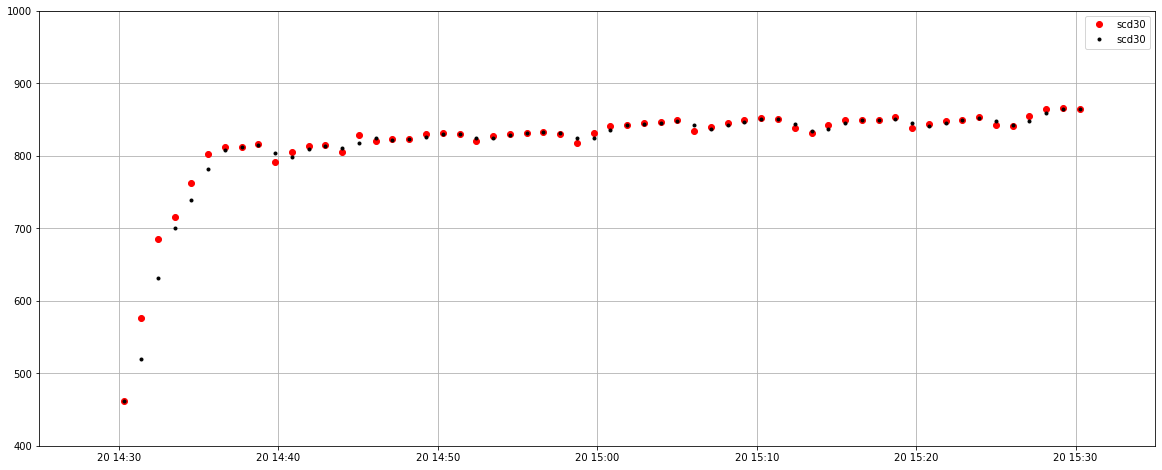

In [8]:
fig, ax = plt.subplots(figsize=(20,8))

fecha1 = parse("2021-07-20 14:25") 
fecha2 = fecha1 + pd.Timedelta("70min")

ax.set_xlim(fecha1,fecha2)
ax.set_ylim(400,1000)

# ax.plot(fluke,"k-o",label="fluke")
ax.plot(sensor,"ro",label=nombre)
ax.plot(sensor.rolling("120S").mean(),"k.",label=nombre)

ax.grid()
ax.legend()